# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run144', 'ORACLE.run120', 'ORACLE.run138', 'ORACLE.run150', 'ORACLE.run18', 'ORACLE.run132', 'ORACLE.run114', 'ORACLE.run126'}


{'Wisig_3', 'Wisig_2', 'Wisig_1', 'Wisig_4'}


tensor([[[ 0.5885, -0.3494, -0.6160,  ..., -0.0690,  0.4321, -1.1401],
         [ 0.6390,  0.1793,  0.3310,  ...,  0.7448, -0.0138, -1.2918]],

        [[ 1.1379,  0.9688, -0.7769,  ...,  0.3382,  0.0411, -1.0373],
         [ 0.1554, -0.1554,  0.9688,  ...,  0.1280, -0.5347, -0.5438]],

        [[-0.4306, -0.2792, -0.4968,  ..., -0.2981,  0.3076,  0.8281],
         [ 1.0126, -0.2035, -0.6199,  ...,  0.9464, -0.0946, -0.5158]],

        ...,

        [[ 0.6796, -0.4440, -1.8032,  ..., -0.2302,  0.6522,  0.5700],
         [-0.7180, -0.1151,  0.8276,  ...,  1.0195,  0.8934, -1.4963]],

        [[-0.4151,  0.1479, -0.1308,  ..., -0.8701, -0.6881, -0.7051],
         [-0.8530,  0.1535,  2.1666,  ...,  0.0341,  0.0853,  0.1990]],

        [[ 0.3724,  0.3231, -0.5312,  ..., -1.0515, -0.6846,  1.3417],
         [ 0.8105, -0.6900, -1.7305,  ..., -0.5203,  0.4764,  0.9803]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.6581, train_label_loss: 2.7695, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 2935.9608, train_label_loss: 1.1903, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3241.0715, train_label_loss: 0.7916, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3440.4350, train_label_loss: 1.1844, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3349.5870, train_label_loss: 0.6901, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3650.4396, train_label_loss: 0.8853, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3791.9448, train_label_loss: 0.5871, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3350.8149, train_label_loss: 0.4603, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3565.1027, train_label_loss: 0.6309, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3970.5759, train_label_loss: 1.1998, 


epoch: 1, source_val_acc_label: 0.6586, target_val_acc_label: 0.6952, source_val_label_loss: 0.9879, target_val_label_loss: 10.2198, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9982, train_label_loss: 0.5370, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3811.1769, train_label_loss: 0.6179, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3857.1148, train_label_loss: 0.6914, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3914.0883, train_label_loss: 0.6772, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 2945.3018, train_label_loss: 0.6670, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3333.7916, train_label_loss: 0.9828, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3408.7805, train_label_loss: 0.5964, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 2981.5725, train_label_loss: 0.7884, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 2948.3265, train_label_loss: 0.5990, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 2972.5293, train_label_loss: 0.7543, 


epoch: 2, source_val_acc_label: 0.6715, target_val_acc_label: 0.7176, source_val_label_loss: 0.8632, target_val_label_loss: 7.2727, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.7308, train_label_loss: 1.2190, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 2932.0394, train_label_loss: 0.7944, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3248.6034, train_label_loss: 0.8706, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3572.2334, train_label_loss: 1.2505, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2942.6930, train_label_loss: 0.5383, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3348.7024, train_label_loss: 0.6522, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3382.2339, train_label_loss: 0.8522, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 2987.7458, train_label_loss: 0.9037, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3000.3532, train_label_loss: 0.6945, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 2981.3393, train_label_loss: 0.5813, 


epoch: 3, source_val_acc_label: 0.7051, target_val_acc_label: 0.7336, source_val_label_loss: 0.8116, target_val_label_loss: 9.0715, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.7365, train_label_loss: 0.3795, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 2955.5634, train_label_loss: 1.1919, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3286.6931, train_label_loss: 0.4557, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3653.2734, train_label_loss: 0.5304, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3009.3893, train_label_loss: 0.8622, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3423.8318, train_label_loss: 0.3780, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3370.5817, train_label_loss: 1.0255, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3002.2246, train_label_loss: 0.6269, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3006.0261, train_label_loss: 0.6661, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3008.6919, train_label_loss: 0.7664, 


epoch: 4, source_val_acc_label: 0.7206, target_val_acc_label: 0.7528, source_val_label_loss: 0.7622, target_val_label_loss: 9.2732, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.7312, train_label_loss: 0.8315, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 2966.9626, train_label_loss: 0.4115, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3261.8932, train_label_loss: 0.4339, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3651.0959, train_label_loss: 0.9535, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3042.3148, train_label_loss: 0.7237, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3446.9627, train_label_loss: 0.2833, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3401.2772, train_label_loss: 0.5643, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 2971.4883, train_label_loss: 0.5392, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 2953.8899, train_label_loss: 0.1975, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 2941.5269, train_label_loss: 0.6105, 


epoch: 5, source_val_acc_label: 0.7283, target_val_acc_label: 0.7537, source_val_label_loss: 0.7565, target_val_label_loss: 9.9645, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7300, train_label_loss: 1.0838, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 2954.0948, train_label_loss: 0.3470, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3263.9770, train_label_loss: 0.6921, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3668.6709, train_label_loss: 0.8961, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3060.6418, train_label_loss: 0.5146, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3420.3163, train_label_loss: 0.3872, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3360.2702, train_label_loss: 0.6168, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3416.0739, train_label_loss: 0.2341, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3427.0972, train_label_loss: 0.9287, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3380.7796, train_label_loss: 0.5386, 


epoch: 6, source_val_acc_label: 0.7204, target_val_acc_label: 0.7697, source_val_label_loss: 0.7508, target_val_label_loss: 9.3053, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9427, train_label_loss: 0.5007, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3910.0510, train_label_loss: 0.5127, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 4130.3192, train_label_loss: 0.4986, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 4815.8960, train_label_loss: 0.4164, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3925.2107, train_label_loss: 0.3019, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3076.1233, train_label_loss: 0.2687, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2975.4469, train_label_loss: 0.4623, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 2954.8984, train_label_loss: 0.4995, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 2979.4895, train_label_loss: 0.6063, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 2968.9724, train_label_loss: 0.2259, 


epoch: 7, source_val_acc_label: 0.7339, target_val_acc_label: 0.7754, source_val_label_loss: 0.7529, target_val_label_loss: 10.6975, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.7242, train_label_loss: 0.3902, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 2980.7489, train_label_loss: 0.1779, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3253.7500, train_label_loss: 0.2452, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3790.5960, train_label_loss: 0.6192, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3569.4151, train_label_loss: 0.2960, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 2977.0807, train_label_loss: 0.4071, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3015.8379, train_label_loss: 0.4107, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3005.3353, train_label_loss: 0.7339, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 2989.2835, train_label_loss: 0.4376, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 2963.6316, train_label_loss: 0.4160, 


epoch: 8, source_val_acc_label: 0.7256, target_val_acc_label: 0.7781, source_val_label_loss: 0.7671, target_val_label_loss: 10.6119, 


New best


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.7374, train_label_loss: 0.3474, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 2981.7800, train_label_loss: 0.1284, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3231.8664, train_label_loss: 0.3473, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3784.4934, train_label_loss: 0.5176, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3503.9934, train_label_loss: 0.4247, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 2955.8713, train_label_loss: 0.4742, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 2998.9895, train_label_loss: 0.2687, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 2979.1302, train_label_loss: 0.3769, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3035.6863, train_label_loss: 1.0482, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3007.7535, train_label_loss: 0.4675, 


epoch: 9, source_val_acc_label: 0.7327, target_val_acc_label: 0.7794, source_val_label_loss: 0.7693, target_val_label_loss: 11.4370, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.7333, train_label_loss: 0.5119, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 2977.1653, train_label_loss: 0.4579, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3227.7059, train_label_loss: 0.6307, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3828.0755, train_label_loss: 0.2643, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3425.7819, train_label_loss: 0.4689, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3000.6800, train_label_loss: 0.6421, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3008.9396, train_label_loss: 0.3607, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 2985.5669, train_label_loss: 0.4911, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3006.1653, train_label_loss: 0.2298, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3001.3362, train_label_loss: 0.5535, 


epoch: 10, source_val_acc_label: 0.7336, target_val_acc_label: 0.7801, source_val_label_loss: 0.7818, target_val_label_loss: 12.2086, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.7309, train_label_loss: 0.5532, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 2973.4381, train_label_loss: 0.4498, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3254.6651, train_label_loss: 0.2362, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3932.8145, train_label_loss: 0.3818, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3378.2454, train_label_loss: 0.7678, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 2994.8225, train_label_loss: 0.4570, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3027.7095, train_label_loss: 0.1049, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 2974.9129, train_label_loss: 0.3636, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 2971.8766, train_label_loss: 0.2821, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3004.2686, train_label_loss: 0.2585, 


epoch: 11, source_val_acc_label: 0.7341, target_val_acc_label: 0.7811, source_val_label_loss: 0.8137, target_val_label_loss: 12.7076, 


New best


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.7386, train_label_loss: 0.2458, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 2935.7176, train_label_loss: 0.1777, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 3238.3884, train_label_loss: 0.3915, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3996.0853, train_label_loss: 0.4462, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 3320.5408, train_label_loss: 0.1380, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 2994.9580, train_label_loss: 0.2612, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3008.9098, train_label_loss: 0.3283, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 2961.9542, train_label_loss: 0.1343, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 2962.1640, train_label_loss: 0.3101, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 2965.9684, train_label_loss: 0.3893, 


epoch: 12, source_val_acc_label: 0.7290, target_val_acc_label: 0.7839, source_val_label_loss: 0.8274, target_val_label_loss: 13.0785, 


New best


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.7368, train_label_loss: 0.5551, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 2931.2050, train_label_loss: 0.2340, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3360.5865, train_label_loss: 0.4096, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 4126.5153, train_label_loss: 0.0566, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3228.3847, train_label_loss: 0.5255, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 2974.1968, train_label_loss: 0.3543, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3004.8625, train_label_loss: 0.3089, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 2985.9433, train_label_loss: 0.2695, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 2982.7718, train_label_loss: 0.2817, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 2986.2894, train_label_loss: 0.1858, 


epoch: 13, source_val_acc_label: 0.7273, target_val_acc_label: 0.7768, source_val_label_loss: 0.8657, target_val_label_loss: 13.7396, 


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.7318, train_label_loss: 0.2288, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 2942.4757, train_label_loss: 0.3896, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 3342.1840, train_label_loss: 0.1437, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 4143.7371, train_label_loss: 0.3458, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 3189.2069, train_label_loss: 0.1915, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 2958.5287, train_label_loss: 0.0677, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 3004.0572, train_label_loss: 0.2637, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 3037.6933, train_label_loss: 0.0125, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 3001.8414, train_label_loss: 0.3420, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 2986.3197, train_label_loss: 0.0666, 


epoch: 14, source_val_acc_label: 0.7217, target_val_acc_label: 0.7809, source_val_label_loss: 0.8766, target_val_label_loss: 14.0469, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.7308, train_label_loss: 0.3821, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 2991.4591, train_label_loss: 0.3445, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 3395.9305, train_label_loss: 0.2553, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 3972.8942, train_label_loss: 0.1138, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 3539.1838, train_label_loss: 0.2090, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 3411.0752, train_label_loss: 0.2013, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 3488.4538, train_label_loss: 0.2107, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3391.4880, train_label_loss: 0.0409, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 3556.1525, train_label_loss: 0.0563, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 3883.0041, train_label_loss: 0.0879, 


epoch: 15, source_val_acc_label: 0.7244, target_val_acc_label: 0.7807, source_val_label_loss: 0.9144, target_val_label_loss: 14.7896, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 1.0068, train_label_loss: 0.1283, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3800.0904, train_label_loss: 0.2537, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 3989.8314, train_label_loss: 0.1132, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 4511.1113, train_label_loss: 0.1763, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3054.3968, train_label_loss: 0.1206, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 2971.5548, train_label_loss: 0.2809, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 3332.6456, train_label_loss: 0.2621, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 3277.6883, train_label_loss: 0.4821, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 2989.8803, train_label_loss: 0.4568, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3171.5706, train_label_loss: 0.0825, 


epoch: 16, source_val_acc_label: 0.7147, target_val_acc_label: 0.7827, source_val_label_loss: 0.9505, target_val_label_loss: 15.1950, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

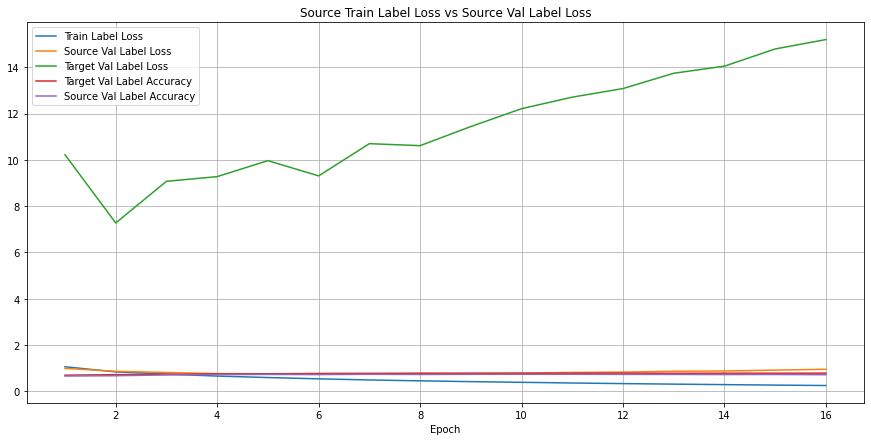

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

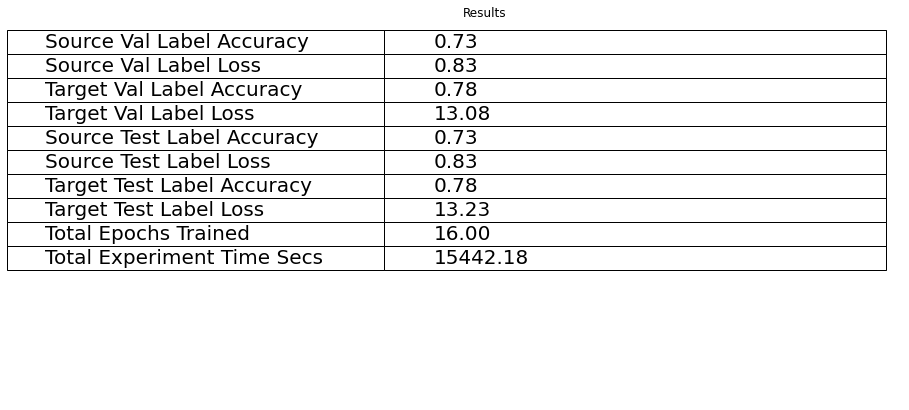

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

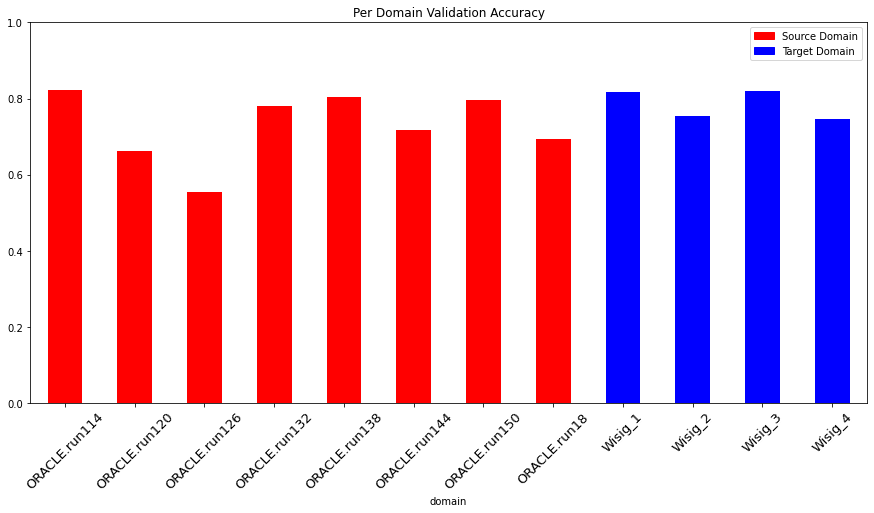

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7265169270833334 Target Test Label Accuracy: 0.7806315104166667
Source Val Label Accuracy: 0.7289713541666667 Target Val Label Accuracy: 0.7839342523860021


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL